# MLOps Team Project: 
# An End-to-End Machine Learning Pipeline on Databricks to Predict Housing Prices in California
### Students: Alex Foster, Natalie Kim, Mathew Spencer, Zoey Zhou
### Due: December 11, 2024

Note: This notebook outlines the end-to-end code. We subsequently broke this up into 6 separate notebooks, which ultimately represented tasks in a Databricks/Airflow workflow.

### Load data

In [0]:
df = spark.read.table('default.housing').toPandas()

In [0]:
df.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

### EDA

In [0]:
df.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

In [0]:
df.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

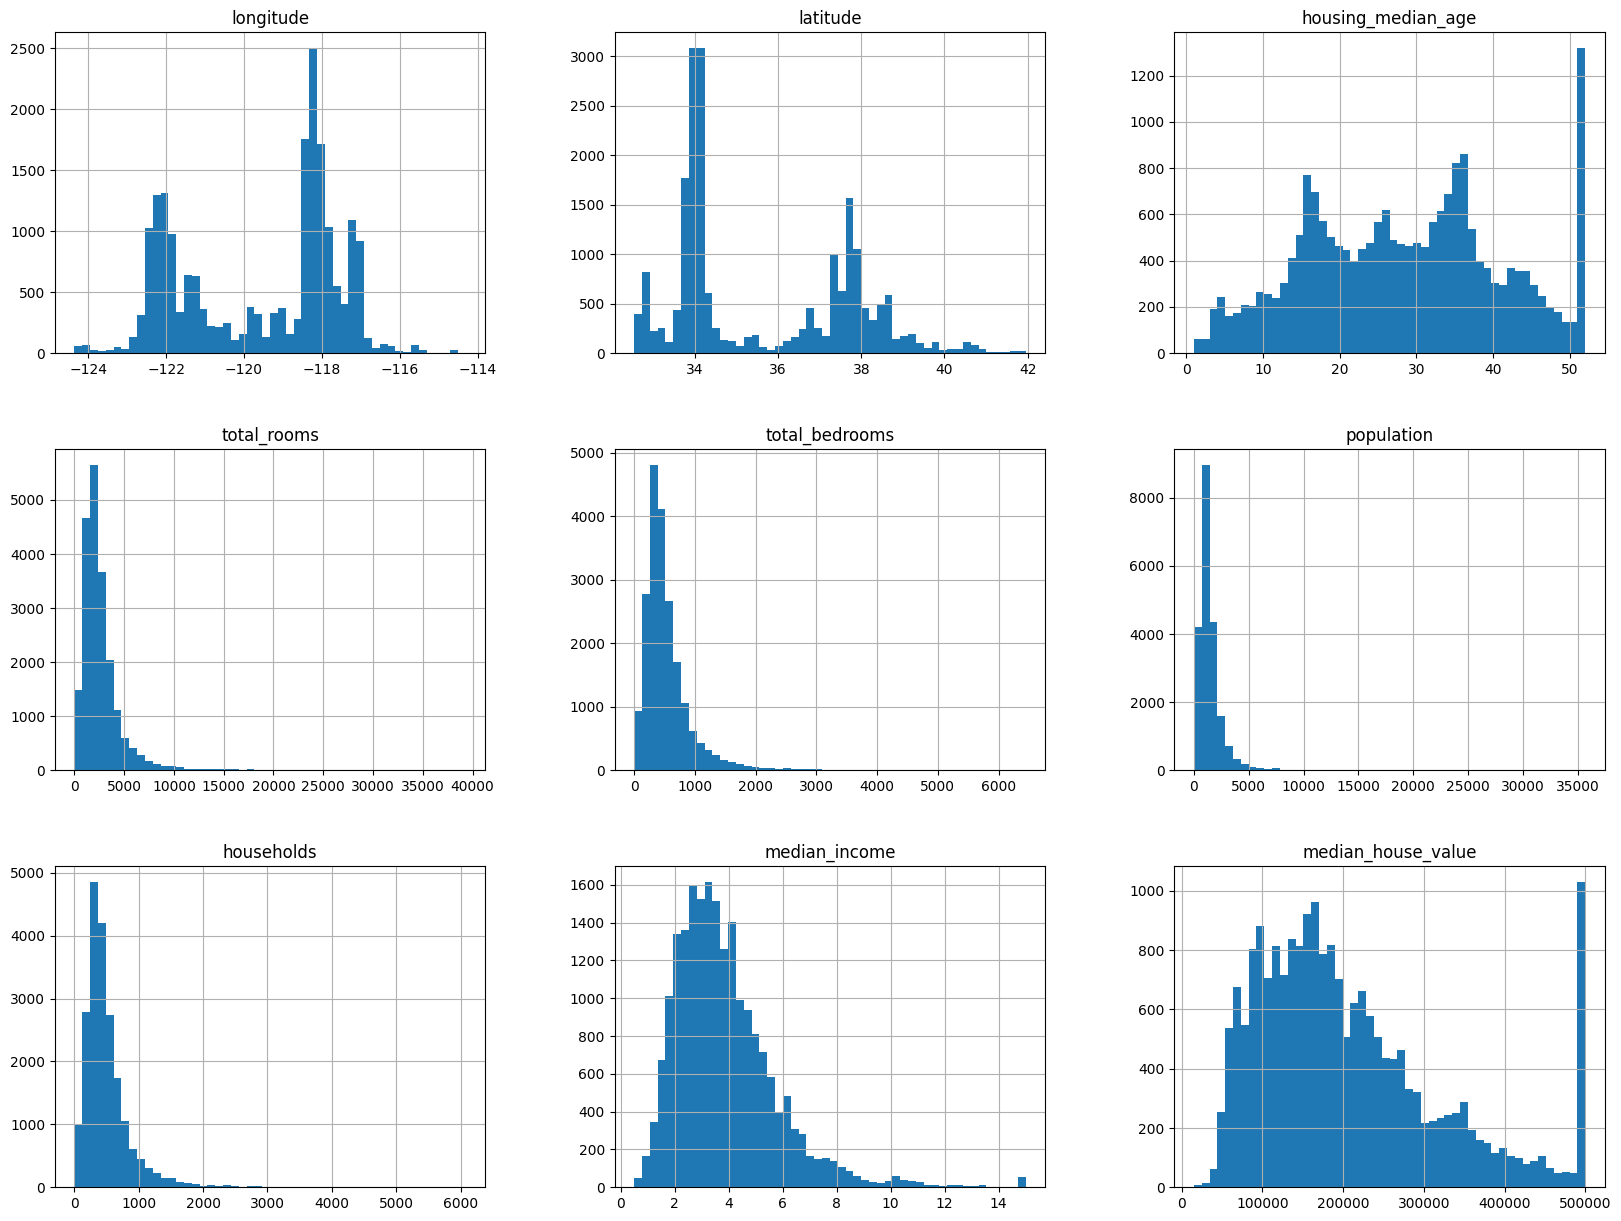

In [0]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20, 15))
plt.show()

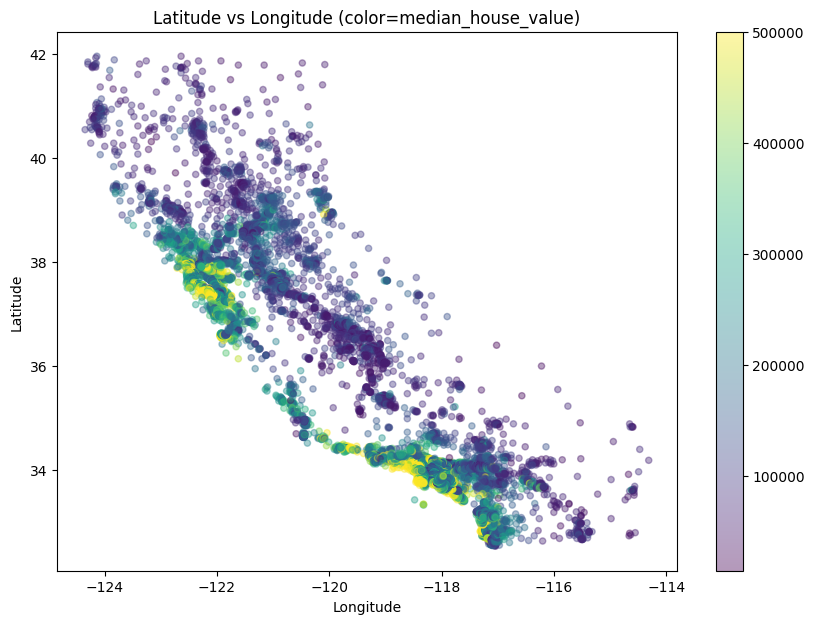

In [0]:
import matplotlib.pyplot as plt

df[['longitude', 'latitude']].plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    c=df['median_house_value'],
    cmap='viridis',
    alpha=0.4,
    figsize=(10, 7)
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Latitude vs Longitude (color=median_house_value)')
plt.show()

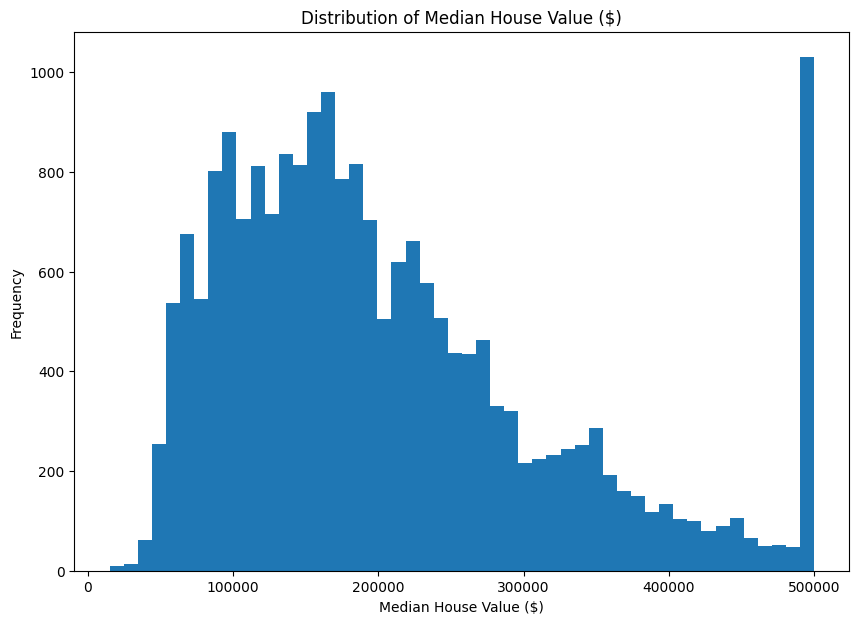

In [0]:
import matplotlib.pyplot as plt

df['median_house_value'].plot(
    kind='hist',
    bins=50,
    figsize=(10, 7),
    title='Distribution of Median House Value ($)'
)
plt.xlabel('Median House Value ($)')
plt.ylabel('Frequency')
plt.show()

In [0]:
# the US census data set capped the value of median_house_value at $500,001. let's remove all those capped observations from the dataset
df = df[df['median_house_value'] != 500001]

# the US census data set capped the value of housing_median_age at 52. let's remove all those capped observations from the dataset
df = df[df['housing_median_age'] != 52]

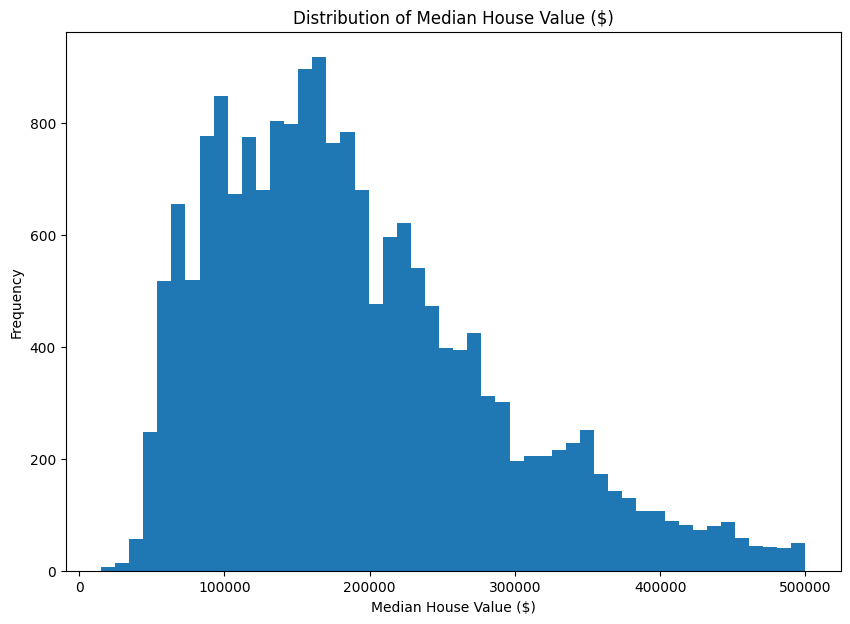

In [0]:
import matplotlib.pyplot as plt

df['median_house_value'].plot(
    kind='hist',
    bins=50,
    figsize=(10, 7),
    title='Distribution of Median House Value ($)'
)
plt.xlabel('Median House Value ($)')
plt.ylabel('Frequency')
plt.show()

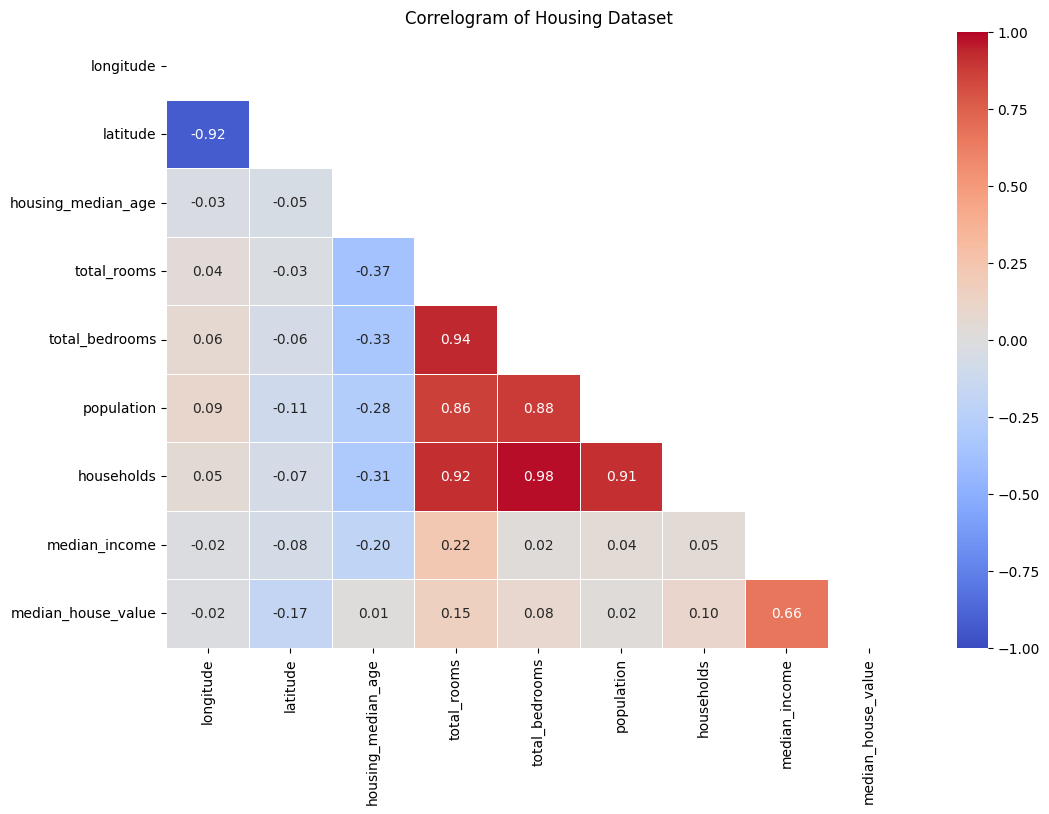

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)

plt.title('Correlogram of Housing Dataset')
plt.show()

### Use AutoML to produce baseline model

In [0]:
import databricks.automl
from datetime import datetime

summary = databricks.automl.regress(
  dataset=df,
  target_col='median_house_value',
  primary_metric='rmse',  
  timeout_minutes=20,
  experiment_name=f"Housing_AutoML_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
  
)

2024/12/06 17:55:41 INFO databricks.automl.client.manager: AutoML will optimize for root mean squared error metric, which is tracked as val_root_mean_squared_error in the MLflow experiment.
2024/12/06 17:55:42 INFO databricks.automl.client.manager: MLflow Experiment ID: 2677676053670375
2024/12/06 17:55:42 INFO databricks.automl.client.manager: MLflow Experiment: https://dbc-7e9bba30-86e9.cloud.databricks.com/?o=773215260201204#mlflow/experiments/2677676053670375
2024/12/06 17:56:54 INFO databricks.automl.client.manager: Data exploration notebook: https://dbc-7e9bba30-86e9.cloud.databricks.com/?o=773215260201204#notebook/2677676053670393
2024/12/06 18:16:10 INFO databricks.automl.client.manager: AutoML experiment completed successfully.


For exploratory data analysis, open the data exploration notebook 
 To view the best performing model, open the best trial notebook 
 To view details about all trials, navigate to the MLflow experiment 
 Metrics for the best trial: 
 
 <!-- class inlined from webapp/web/js/templates/iframeSandbox.css -->
 
 
 
 
 
 Train 
 Validation 
 Test 
 
 
 
 
 
 root_mean_squared_error 
 27895.087 
 41983.282 
 40468.132 
 
 

 
 mean_squared_error 
 7.781359e+08 
 1.762596e+09 
 1.637670e+09 
 
 

 
 example_count 
 11173.000 
 3650.000 
 3749.000 
 
 

 
 r2_score 
 0.917 
 0.809 
 0.811 
 
 

 
 sum_on_target 
 2.123625e+09 
 6.886679e+08 
 7.091000e+08 
 
 

 
 score 
 0.917 
 0.809 
 0.811 
 
 

 
 mean_absolute_error 
 18767.853 
 27894.478 
 27963.118 
 
 

 
 mean_on_target 
 190067.538 
 188676.137 
 189143.772 
 
 

 
 max_error 
 211085.844 
 343399.234 
 268405.938 
 
 

 
 mean_absolute_percentage_error 
 0.112 
 0.165 
 0.165

In [0]:
from mlflow.tracking import MlflowClient
import mlflow
import mlflow.sklearn


# fetch experiment ID from autoML summary
experiment_id = summary.experiment.experiment_id

# initialize mlFlow client
client = MlflowClient()

# search for best run
runs = client.search_runs(
    experiment_ids=[experiment_id],
    order_by=['metrics.val_root_mean_squared_error'],
    max_results=1
)

if runs:
    best_run = runs[0]
    # Print the details of the best run
    print(f'Best Run ID: {best_run.info.run_id}')


    # Load the best model
    model_uri = f'runs:/{best_run.info.run_id}/model'
    best_model = mlflow.pyfunc.load_model(model_uri)

else:
    print('no runs found')

Best Run ID: 64ae13f8bbb04850b3b56c6cc1cb4df2


In [0]:
# Load and visualize the best model
best_model = mlflow.sklearn.load_model(model_uri)
best_model

Pipeline(steps=[('column_selector',
                 ColumnSelector(cols=['ocean_proximity', 'latitude',
                                      'median_income', 'housing_median_age',
                                      'households', 'longitude', 'population',
                                      'total_bedrooms', 'total_rooms'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(fun...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.025160659815936983, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=12,
                              max_leaves=None, min_child_weight=10, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=979, n_jobs=100,
                              num_parallel_tree=None, random_state=250565141, ...))])

### Improve on Baseline Model

### Data Processing (Cleanup + Feature Engineering)

In [0]:
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

# define processing for columns based on type
numerical_features = df.select_dtypes(include=['int64','float64']).columns
numerical_transformer = SimpleImputer(strategy='mean')
categorical_features = df.select_dtypes(include=['object']).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# combine processing steps 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# apply processing steps 
df_processed = preprocessor.fit_transform(df)

# convert to DataFrame 
df_processed = pd.DataFrame(
    df_processed,
    columns=numerical_features.tolist()+preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
)

# create new features
df_processed['rooms_per_household'] = df_processed['total_rooms'] / df_processed['households']
df_processed['bedrooms_per_room'] = df_processed['total_bedrooms'] / df_processed['total_rooms']
df_processed['population_per_household'] = df_processed['population'] / df_processed['households']

# clean up column name for subsequent processing steps
df_processed = df_processed.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_1H OCEAN'})

In [0]:
df_processed.describe()

longitude      latitude  ...  bedrooms_per_room  population_per_household
count  18572.000000  18572.000000  ...       18572.000000              18572.000000
mean    -119.484929     35.593231  ...           0.215369                  3.108596
std        1.980865      2.147712  ...           0.064392                 10.811650
min     -124.300000     32.540000  ...           0.046802                  0.692308
25%     -121.550000     33.920000  ...           0.177010                  2.469421
50%     -118.450000     34.240000  ...           0.203977                  2.855824
75%     -117.970000     37.670000  ...           0.240827                  3.320622
max     -114.310000     41.950000  ...           2.302538               1243.333333

[8 rows x 17 columns]

### Split Data

In [0]:
from sklearn.model_selection import train_test_split

# split data into train/val/test
X = df_processed.drop(columns=['median_house_value'])
y = df_processed['median_house_value']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Hyperparameter Tuning

In [0]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.metrics import root_mean_squared_error
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient

In [0]:
# define search space for hyperparameters
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

# define objective function for tuning
def objective(params):
    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return {'loss': rmse,'status': STATUS_OK}

# initialize MLflow
mlflow.set_experiment('/Users/matspencer@uchicago.edu/Housing_HPT')

# run hyperparemeter tuning
with mlflow.start_run(run_name='xgb_hyperopt'):
    best_params = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=50,
        trials=Trials()
    )

print('Best parameters found: ', best_params)

100%|██████████| 50/50 [00:53<00:00,  1.07s/trial, best loss: 38938.91256206782]
Best parameters found:  {'colsample_bytree': 0.6121693498065617, 'learning_rate': 0.10128664688350145, 'max_depth': 8.0, 'n_estimators': 354.0, 'subsample': 0.953451254504716}


### Model Training

In [0]:
# ensure all parameters have the correct data types
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params

{'colsample_bytree': 0.6121693498065617,
 'learning_rate': 0.10128664688350145,
 'max_depth': 8,
 'n_estimators': 354,
 'subsample': 0.953451254504716}

In [0]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

# train model selected by AutoML with parameters discovered in tuning step
best_model = xgb.XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# predict on validation set
y_val_pred = best_model.predict(X_val)

# calculate validation metrics 
rmse = root_mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
mape = mean_absolute_percentage_error(y_val, y_val_pred)

print(f'Validation RMSE: {rmse}')
print(f'Validation R2: {r2}')
print(f'Validation MAPE: {mape}')

# log final model and metrics with MLflow
with mlflow.start_run(run_name='final_xgb_model'):
    mlflow.xgboost.log_model(best_model, 'model',
    registered_model_name='xgb_housing_model')
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.log_metric('mape', mape)


[0]	validation_0-rmse:90475.08142
[1]	validation_0-rmse:85795.75036
[2]	validation_0-rmse:80794.48484
[3]	validation_0-rmse:76728.50269
[4]	validation_0-rmse:72923.27399
[5]	validation_0-rmse:69958.45821
[6]	validation_0-rmse:66558.22274
[7]	validation_0-rmse:64581.04916
[8]	validation_0-rmse:62655.87602
[9]	validation_0-rmse:60796.41477
[10]	validation_0-rmse:58940.62191
[11]	validation_0-rmse:57457.70943
[12]	validation_0-rmse:55314.75738
[13]	validation_0-rmse:53831.61042
[14]	validation_0-rmse:52494.44831
[15]	validation_0-rmse:51156.26390
[16]	validation_0-rmse:50421.85135
[17]	validation_0-rmse:49757.81626
[18]	validation_0-rmse:49123.14965
[19]	validation_0-rmse:48576.31566
[20]	validation_0-rmse:48210.08020
[21]	validation_0-rmse:47650.93569
[22]	validation_0-rmse:47244.44094
[23]	validation_0-rmse:46798.24341
[24]	validation_0-rmse:46289.87258
[25]	validation_0-rmse:45847.13959
[26]	validation_0-rmse:45629.60716
[27]	validation_0-rmse:45155.89741
[28]	validation_0-rmse:44822.2

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Registered model 'xgb_housing_model' already exists. Creating a new version of this model...
Created version '12' of model 'xgb_housing_model'.


  0%|          | 0/100 [00:00<?, ?it/s]

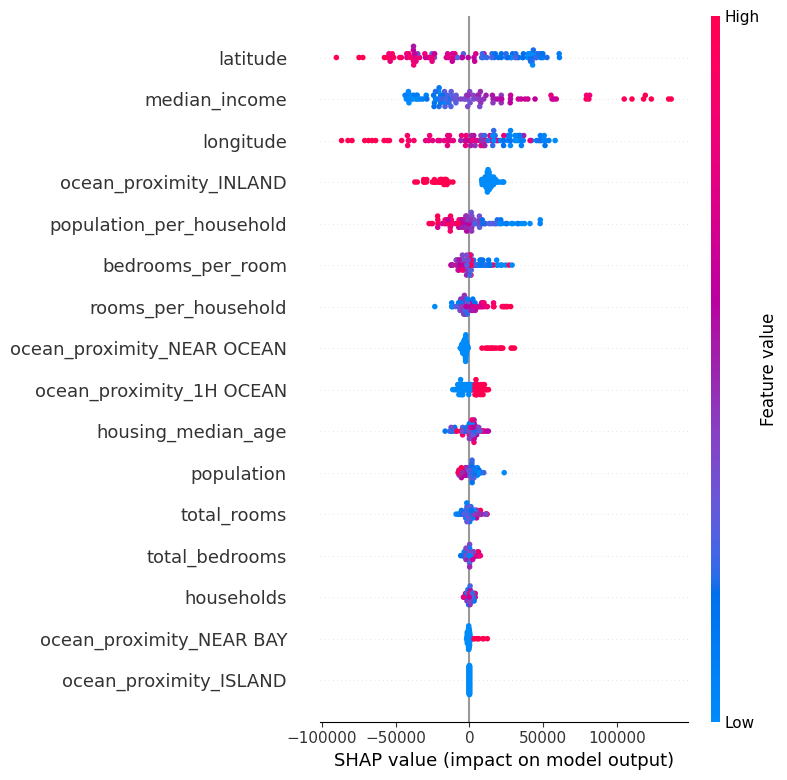

In [0]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = True
if shap_enabled:
    mlflow.autolog(disable=True)
    mlflow.sklearn.autolog(disable=True)
    from shap import KernelExplainer, summary_plot
    # SHAP cannot explain models using data with nulls.
    # To enable SHAP to succeed, both the background data and examples to explain are imputed with the mode (most frequent values).
    mode = X_train.mode().iloc[0]

    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]), random_state=61339316).fillna(mode)

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(100, X_val.shape[0]), random_state=61339316).fillna(mode)

    # Use Kernel SHAP to explain feature importance on the sampled rows from the validation set.
    predict = lambda x: best_model.predict(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="identity")
    shap_values = explainer.shap_values(example, l1_reg=False, nsamples=500)
    summary_plot(shap_values, example)

### Load Registered Model, Run Inference on Test Data

In [0]:
import numpy as np 

# load registered model
model_name = 'xgb_housing_model'
model_version = 'latest'
model_uri = f'models:/{model_name}/{model_version}'
loaded_model = mlflow.xgboost.load_model(model_uri)

# run inference on test data
y_test_pred = loaded_model.predict(X_test)

# calculate test metrics 
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')
print(f'Test MAPE: {test_mape}')

Test RMSE: 40583.727698151495
Test R2: 0.8284290591741955
Test MAPE: 0.1516323119149684


In [0]:
# set up model monitoring with EvidentlyAI
# %pip install evidently
from evidently.ui.workspace.cloud import CloudWorkspace

from evidently.report import Report

from evidently import metrics
from evidently.metric_preset import DataQualityPreset
from evidently.metric_preset import DataDriftPreset
from evidently.metrics import RegressionPerformanceMetrics

from evidently.test_suite import TestSuite
from evidently.tests import *
from evidently.test_preset import DataDriftTestPreset
from evidently.tests.base_test import TestResult, TestStatus

from evidently.ui.dashboards import DashboardPanelPlot
from evidently.ui.dashboards import DashboardPanelTestSuite
from evidently.ui.dashboards import PanelValue
from evidently.ui.dashboards import PlotType
from evidently.ui.dashboards import ReportFilter
from evidently.ui.dashboards import TestFilter
from evidently.ui.dashboards import TestSuitePanelType
from evidently.renderers.html_widgets import WidgetSize

In [0]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [0]:
reference_data = X_val.copy() # start with val data
reference_data['target'] = y_val # add actual target values
reference_data['prediction'] = loaded_model.predict(X_val) # add model predictions

current_data = X_test.copy() # start with test features
current_data['target'] = y_test # add actual target values
current_data['prediction'] = loaded_model.predict(X_test) # add model predictions to the test data

# create a report with both Data Drift and Performance Monitoring
report = Report(metrics=[
    DataDriftPreset(),
    RegressionPerformanceMetrics()
])

# run the report
report.run(reference_data=reference_data, current_data=current_data)
report

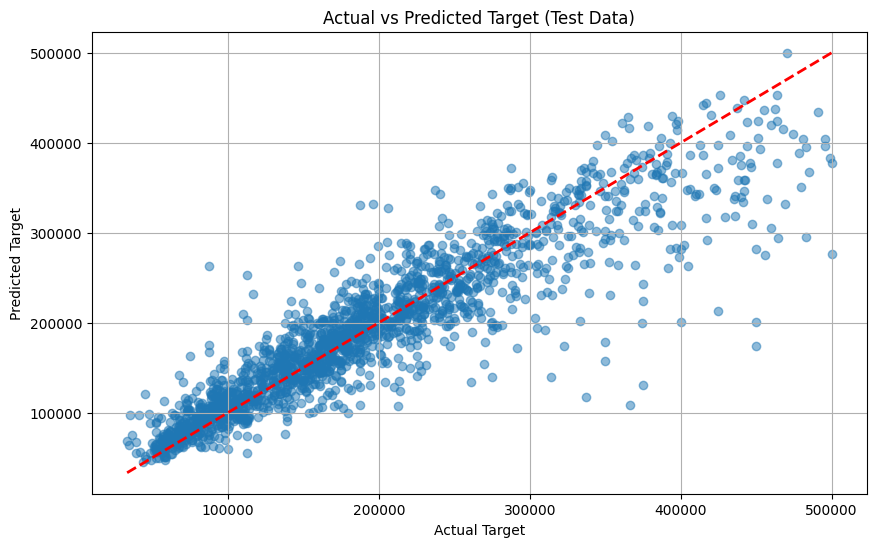

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(current_data['target'], current_data['prediction'], alpha=0.5)
plt.plot([current_data['target'].min(), current_data['target'].max()], 
         [current_data['target'].min(), current_data['target'].max()], 
         color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Actual vs Predicted Target (Test Data)')
plt.grid(True)
plt.show()

### Modify the Data to Ensure Model Monitoring Works

In [0]:
# modify data (2 features) according to assignment prompt
current_data['rooms_per_household'] = current_data['rooms_per_household']*1.2
current_data['median_income'] = current_data['median_income']*1.2

# prepare a dataframe that we can make predictions on
X_test_current = current_data.drop(columns=['target', 'prediction'])

# re-run predictions on modified current_data
current_data['prediction'] = loaded_model.predict(X_test_current) # make predictions on modified current_data and add to dataframe

# run the report
report.run(reference_data=reference_data, current_data=current_data)
report

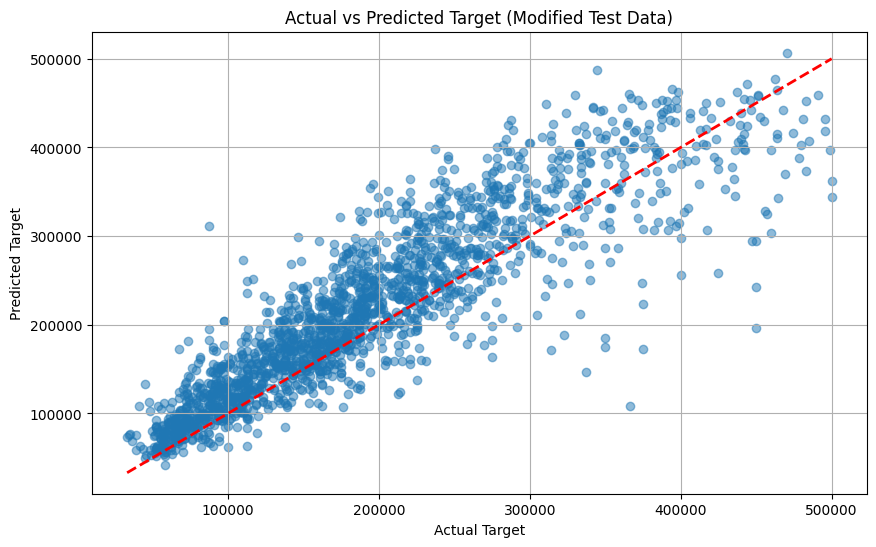

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(current_data['target'], current_data['prediction'], alpha=0.5)
plt.plot([current_data['target'].min(), current_data['target'].max()], 
         [current_data['target'].min(), current_data['target'].max()], 
         color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Actual vs Predicted Target (Modified Test Data)')
plt.grid(True)
plt.show()